In [45]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
import sys
sys.path.append('/gdrive/MyDrive/hw3')

In [ ]:
# --- imports ---
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import hw3utils
torch.multiprocessing.set_start_method('spawn', force=True)

In [ ]:
# ---- utility functions -----
def get_loaders(batch_size,device):
    train_set = hw3utils.HW3ImageFolder('/gdrive/MyDrive/hw3/ceng483-hw3-dataset/train',device=device)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    val_set = hw3utils.HW3ImageFolder('/gdrive/MyDrive/hw3/ceng483-hw3-dataset/val',device=device)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)
    return train_loader, val_loader

In [ ]:
class Net2(nn.Module):
    def __init__(self, num_kernels):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, num_kernels, 3, padding=1)
        self.conv2 = nn.Conv2d(num_kernels, 3, 3, padding=1)

    def forward(self, grayscale_image):
        x = F.relu(self.conv1(grayscale_image))
        x = self.conv2(x)
        return x

In [ ]:
def train_and_evaluate(net, train_loader, val_loader, lr, max_num_epoch, device, patience=3):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    train_losses, val_losses_x, val_losses_y, margin_errors, yy = [], [], [], [],[]
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(max_num_epoch):
        net.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        if (epoch + 1) % 5 == 0 or epoch == 0:
            net.eval()
            val_loss, margin_error = 0.0, 0.0
            with torch.no_grad():
                for val_inputs, val_targets in val_loader:
                    val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                    val_outputs = net(val_inputs)
                    val_loss += criterion(val_outputs, val_targets).item()
                    margin_error += (torch.abs(torch.sub(val_outputs, val_targets)) > 24.0/255.0).sum().to(dtype=torch.float) / float(val_outputs.reshape(-1).shape[0])

            val_losses_x.append(epoch)
            val_losses_y.append(val_loss / len(val_loader))
            margin_errors.append(margin_error / len(val_loader))
            yy.append(epoch)

            if val_losses_y[-1] < best_val_loss:
                best_val_loss = val_losses_y[-1]
                epochs_no_improve = 0
                torch.save(net.state_dict(), '/gdrive/MyDrive/hw3/best_model.pt')
            else:
                epochs_no_improve += 1

            if epochs_no_improve == patience:
                print(f'Early stopping triggered at epoch {epoch+1}')
                print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses_y[-1]:.4f}, 12-Margin Error: {margin_errors[-1]:.4f}, Accuracy: {1 - margin_errors[-1]:.4f}')
                break

            print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses_y[-1]:.4f}, 12-Margin Error: {margin_errors[-1]:.4f}, Accuracy: {1 - margin_errors[-1]:.4f}')

        torch.save(net.state_dict(), '/gdrive/MyDrive/hw3/best_model.pt')
        hw3utils.visualize_batch(val_inputs[:5], val_outputs[:5], val_targets[:5], '/gdrive/MyDrive/hw3/images.png')

    accuracies = [1 - x for x in margin_errors]


    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses_x, val_losses_y, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(yy, margin_errors, label='12-Margin Error')
    plt.title('12-Margin Error over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(yy,accuracies, label='Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [ ]:
train_loader, val_loader = get_loaders(batch_size=16,device='cuda:0')

In [ ]:
device = 'cpu'

Epoch 1, Train Loss: 0.0126, Val Loss: 0.0094, 12-Margin Error: 0.2544, Accuracy: 0.7456
Epoch 5, Train Loss: 0.0084, Val Loss: 0.0083, 12-Margin Error: 0.2277, Accuracy: 0.7723
Epoch 10, Train Loss: 0.0083, Val Loss: 0.0083, 12-Margin Error: 0.2291, Accuracy: 0.7709
Epoch 15, Train Loss: 0.0083, Val Loss: 0.0082, 12-Margin Error: 0.2276, Accuracy: 0.7724
Epoch 20, Train Loss: 0.0082, Val Loss: 0.0083, 12-Margin Error: 0.2284, Accuracy: 0.7716
Epoch 25, Train Loss: 0.0082, Val Loss: 0.0085, 12-Margin Error: 0.2297, Accuracy: 0.7703
Early stopping triggered at epoch 30
Epoch 30, Train Loss: 0.0082, Val Loss: 0.0083, 12-Margin Error: 0.2293, Accuracy: 0.7707


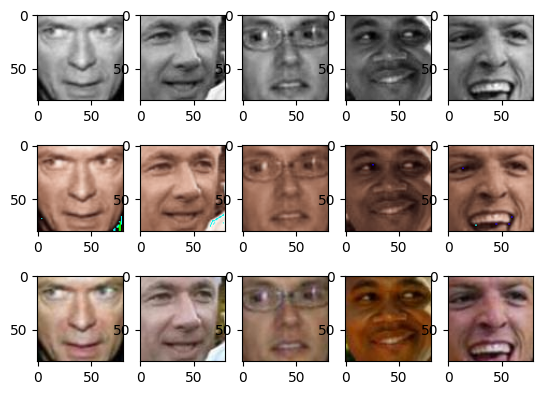

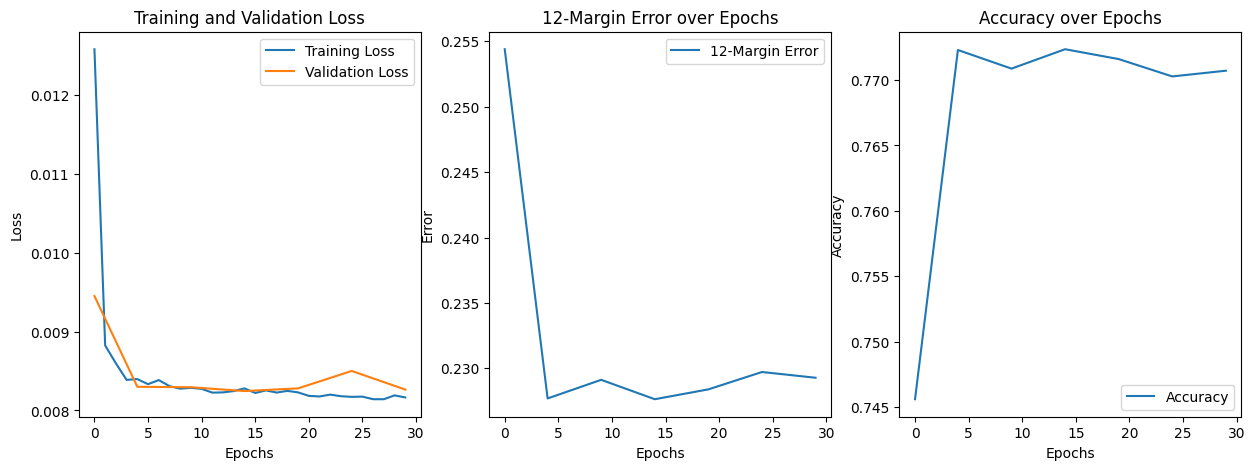

In [ ]:
torch.manual_seed(1)
net= Net2(16).to(device)
train_and_evaluate(net, train_loader, val_loader, lr=0.1, max_num_epoch=100, device=device)

In [ ]:
model = Net2(16).to(device)
model.load_state_dict(torch.load('/gdrive/MyDrive/hw3/best_model.pt'))
model.eval()

Net2(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
test_set = hw3utils.HW3ImageFolder('/gdrive/MyDrive/hw3/test_images',device=device)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False, num_workers=0)

In [ ]:
for index in range(100):
    myfile = open('test_images.txt', 'a')
    path = '/gdrive/MyDrive/hw3/test_images/images_grayscale/' + str(index) + '.jpg'
    myfile.write(path)
    myfile.write('\n')
    myfile.close()

In [ ]:
for test_inputs, test_targets in test_loader:
    test_preds = model(test_inputs)
    testnp = test_preds.detach().numpy()
    testnp = (testnp/2+0.5)*255
    testnp = testnp.astype('int')
    testnp = testnp.reshape(100, 80, 80, 3)
    np.save('/gdrive/MyDrive/hw3/test_images/images_grayscale/estimations_test.npy', testnp)